In [2]:
import pandas as pd
import seaborn as sns
from sqlite3 import connect
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
pri

In [3]:
# connection to database
conn = connect('lazac.sqlite3')

playground_detail = pd.read_sql(
    'SELECT * FROM customers_playgrounddetail WHERE playground_id = 3',
    conn,
    index_col='date',
    parse_dates=['date']
)

customers = pd.read_sql(
    'SELECT * FROM customers_customer WHERE playground_id = 3 AND status = \'finished\' AND cost > 10',
    conn,
    index_col='id',
    parse_dates=['start_time', 'end_time']
)

In [4]:
playground_detail.head()

,id,total_amount,playground_id,rate
date,,,,
2024-04-23,3,0,3,350
2024-04-25,15,6350,3,350
2024-04-26,91,6150,3,350
2024-04-27,123,9550,3,350
2024-04-28,125,7750,3,350


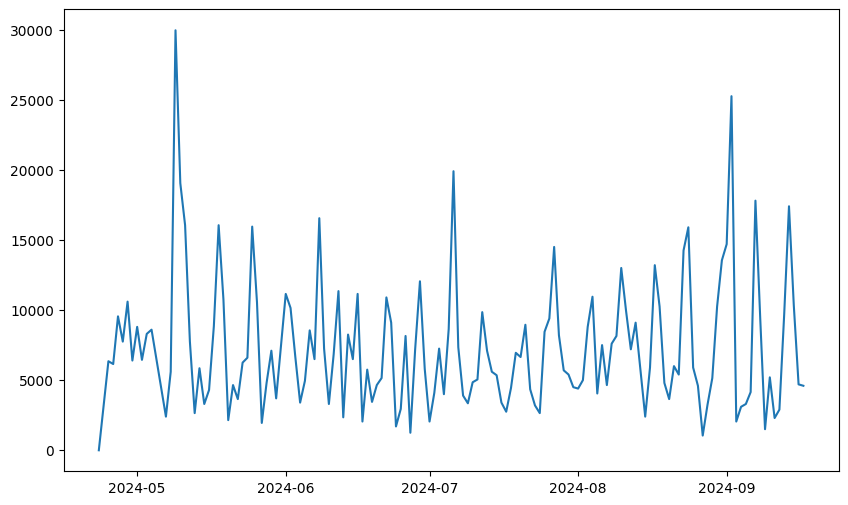

In [5]:
plt.figure(figsize=(10,6))
plt.plot(playground_detail['total_amount']);

In [6]:
pdd = playground_detail.reset_index()

In [7]:
x = pdd.index.values.reshape(-1,1)
y = pdd['total_amount'].values.reshape(-1, 1)

regressor = LinearRegression()
regressor.fit(x,y)

[pdd['total_amount'].mean(), regressor.coef_, regressor.intercept_]

[np.float64(7303.9375), array([[-1.70412547]]), array([7425.78247126])]

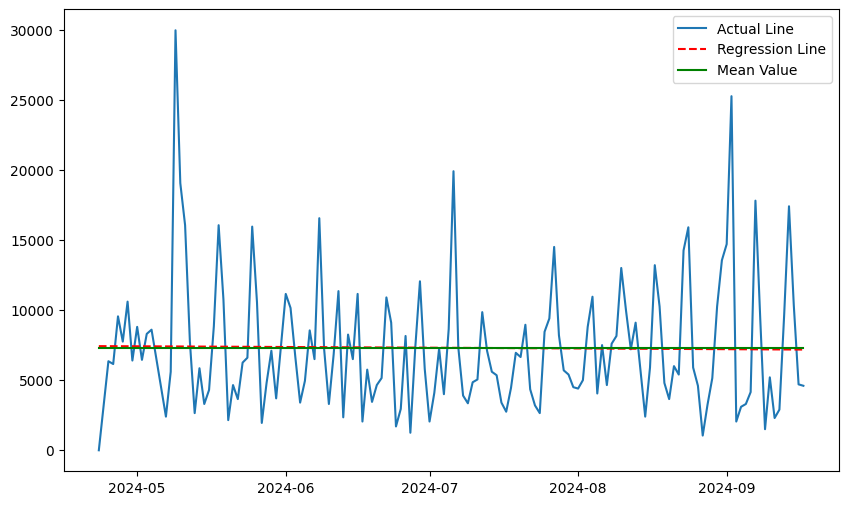

In [8]:
plt.figure(figsize=(10,6))
plt.plot(pdd['date'], y, label='Actual Line')
plt.plot(pdd['date'], [regressor.coef_.flatten()[0] * i + regressor.intercept_.flatten()[0] for i in range(len(x))], 'r--', label='Regression Line')
plt.plot(pdd['date'], [pdd['total_amount'].mean()] * len(pdd['date']), 'g-', label='Mean Value')
plt.legend()
plt.show()

### Without outliers

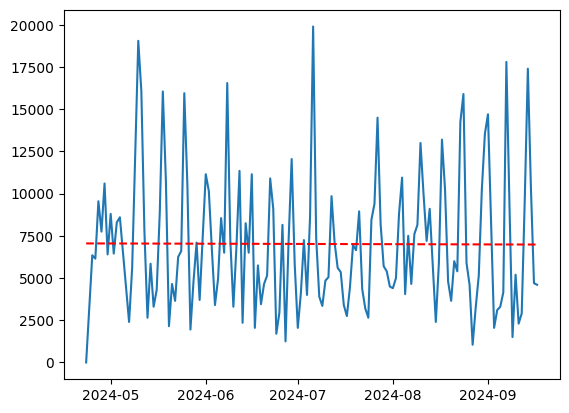

In [9]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(pdd['total_amount']))
threshold = 3

pdd_cleaned = pdd[z < threshold]

x_cl = pdd_cleaned.index.values.reshape(-1,1)
y_cl = pdd_cleaned['total_amount'].values.reshape(-1, 1)
regressor_cleaned = LinearRegression()
regressor_cleaned.fit(x_cl, y_cl)

plt.plot(pdd_cleaned['date'], pdd_cleaned['total_amount'])
# plt.plot(pdd['date'], [regressor.coef_.flatten()[0] * i + regressor.intercept_.flatten()[0] for i in range(len(x))], 'r--', label='Regression Line')

plt.plot(pdd['date'], [regressor_cleaned.coef_.flatten()[0] * i + regressor_cleaned.intercept_.flatten()[0] for i in range(len(x))], 'r--', label='Regression Line')
plt.show()

In [10]:
[regressor_cleaned.coef_.flatten()[0], regressor_cleaned.intercept_.flatten()[0]]

[np.float64(-0.46492201054878046), np.float64(7051.325936740302)]

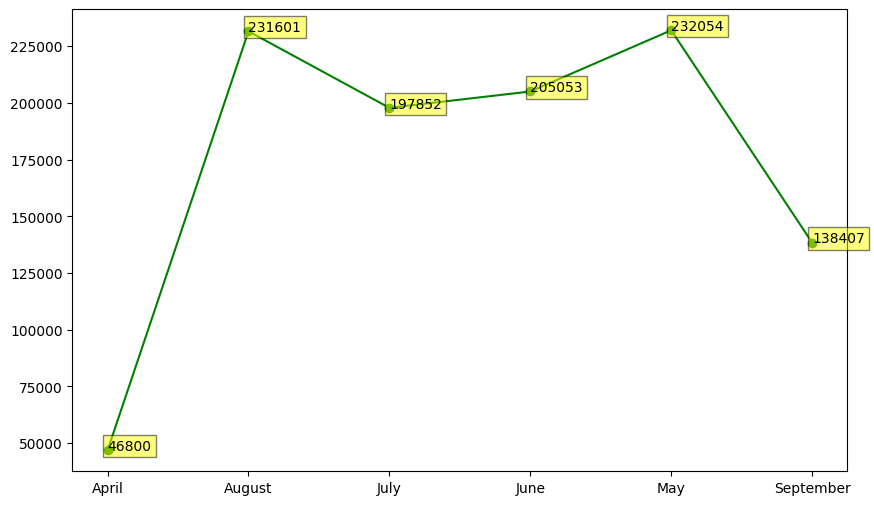

In [11]:
playground_detail['month'] = playground_detail.index.month_name()
amount_by_month = playground_detail.groupby('month')[['total_amount']].sum()
month_list = amount_by_month.index.values
amount_list = amount_by_month['total_amount'].values

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(amount_by_month['total_amount'], 'go-')
for i, label in enumerate(amount_list):
    # ax.annotate(label, (month_list[i], amount_list[i]), textcoords="offset points", 
    #             xytext=(15,-20),  # Offset text slightly above the point
    #             ha='center', 
    #             arrowprops=dict(arrowstyle="-", color='black'))
    bbox_props = dict(boxstyle='square,pad=0.3', facecolor='yellow', alpha=0.5)
    ax.text(month_list[i], amount_list[i], label, bbox=bbox_props)
plt.show()

In [12]:
customers.head()

,gender,customer_type,name,hours,end_time,status,playground_id,cost,playground_detail_id,bank,payment,start_time
id,,,,,,,,,,,,
54,female,returning,Девочка с мамой 350,1.0,2024-09-22 13:04:56,finished,3,350,15,None,cash,2024-04-25 09:35:03
55,male,returning,Даня 700,2.0,2024-09-22 13:04:56,finished,3,700,15,sberbank,card,2024-04-25 09:48:35
56,male,returning,Иван 350 89037206912,1.0,2024-09-22 13:04:56,finished,3,350,15,tinkoff,card,2024-04-25 10:15:08
57,female,returning,Вероника 350 9363333715,1.0,2024-09-22 13:04:56,finished,3,350,15,sberbank,card,2024-04-25 11:44:01
58,male,returning,Али 350,1.0,2024-09-22 13:04:56,finished,3,350,15,tinkoff,card,2024-04-25 12:58:25


In [13]:
customers['start_time'] = pd.to_datetime(customers['start_time']).dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
customers['date'] = customers['start_time'].dt.date
customers['time'] = customers['start_time'].dt.hour

In [14]:
cost_by_hour = customers.groupby(['date', 'time'])[['cost']].sum()
cost_by_hour

cost
date       time      
2024-04-25 12    1050
           13     350
           14     350
           15     350
           17    1300
...               ...
2024-09-17 11     500
           13    1000
           14     500
           16     600
           18    2000

[983 rows x 1 columns]

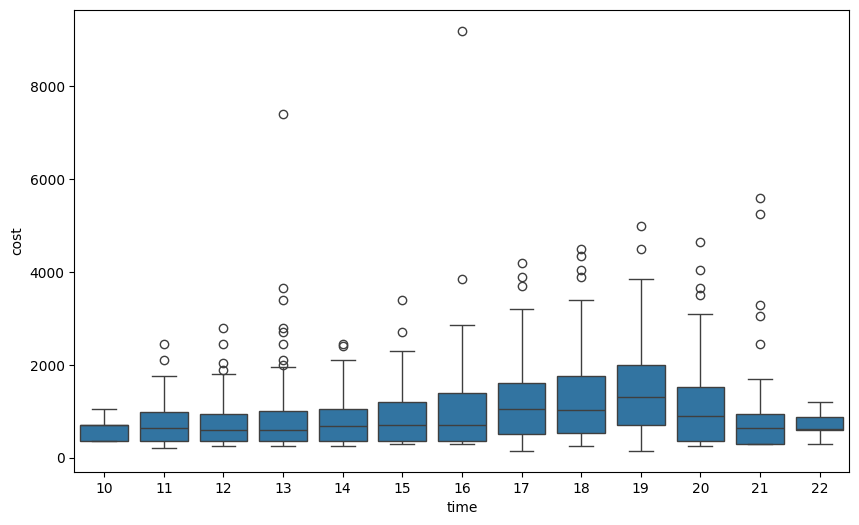

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x = 'time', y = 'cost', data = cost_by_hour)
plt.show()

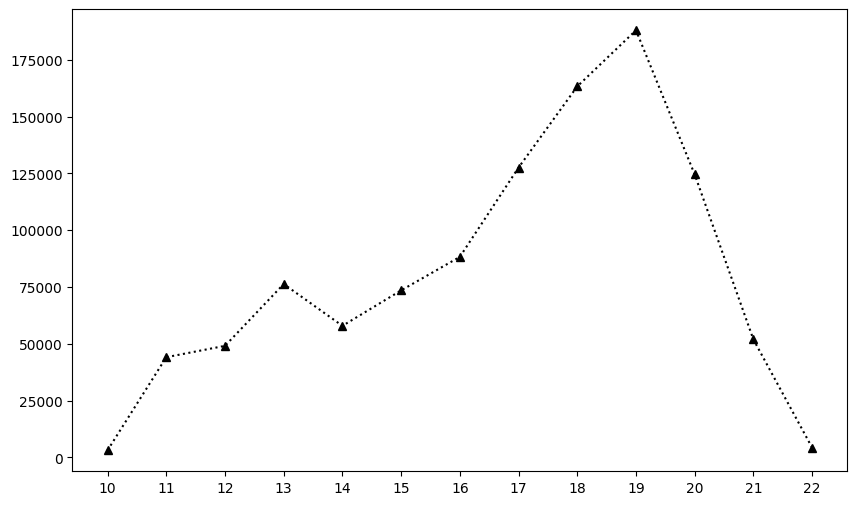

In [16]:
cust_by_time = customers.groupby(['time'])[['cost']].sum()
plt.figure(figsize=(10,6))
plt.xticks([i for i in cust_by_time.index])
plt.plot(cust_by_time['cost'], '^k:')
plt.show()

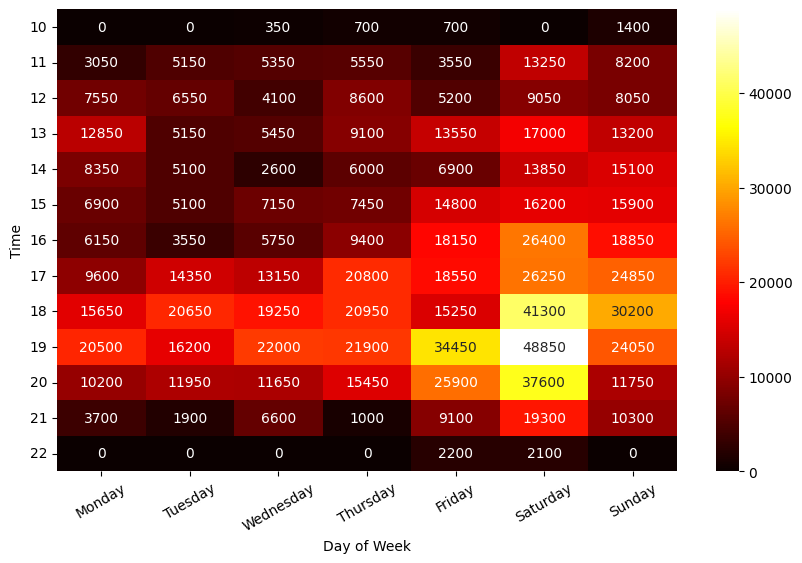

In [17]:
customers['weekday'] = customers['start_time'].dt.dayofweek
customers['weekday_name'] = customers['start_time'].dt.day_name()
cost_by_dayweek = customers.pivot_table(values='cost', index='time', columns=['weekday', 'weekday_name'], aggfunc='sum', fill_value=0)
cost_by_dayweek.columns = cost_by_dayweek.columns.get_level_values(1)
fig, ax = plt.subplots(figsize=(10,6))
sns_cost_by_dayweek = sns.heatmap(cost_by_dayweek, annot=True, fmt='.0f', cmap='hot', ax=ax)
plt.xlabel("Day of Week")
plt.ylabel("Time")
plt.xticks(rotation=30);
plt.yticks(rotation=0);